In [2]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import numpy as np
from urllib.request import urlopen
import json
with urlopen('https://raw.githubusercontent.com/plotly/datasets/master/geojson-counties-fips.json') as response:
    counties = json.load(response)
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import LinearRegression, RidgeCV, LarsCV, Ridge, Lasso, LassoCV
from regressors import stats    
from sklearn.feature_selection import chi2

In [3]:
#Set some pandas parameters for outputs
pd.set_option('display.max_columns', 5)
pd.set_option('display.width', 1000)

In [14]:
### Define function for US map plotting ###
def plotByState(dataset, valueColName, colorbarLabel, stateColName = "State", countyColName = "FIPS Code", saveFilePath = "data/education/educationLevelsState.html"):
    #Extract only state data
    dataset = dataset[[countyColName, stateColName, valueColName]]
    datasetStates = dataset[dataset[countyColName]%1000 == 0]

    valueRange = (min(datasetStates[valueColName]), max(datasetStates[valueColName]))

    fig = px.choropleth(datasetStates, locations=datasetStates[stateColName], locationmode="USA-states",
    color=valueColName,color_continuous_scale="Viridis",
    range_color=valueRange,scope="usa",labels={valueColName:colorbarLabel},
    hover_name=stateColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.update_layout(coloraxis_colorbar=dict(lenmode="pixels", len=600))
    fig.write_html(saveFilePath, auto_open=True)

def plotByCounty(dataset, valueColName, countyColName = "FIPS Code"):
    #Extract only state data
    dataset = dataset[dataset[countyColName]%1000 != 0]

    fig = px.choropleth(dataset, geojson=counties, locations=countyColName, 
    color=valueColName,color_continuous_scale="Viridis", range_color=(0, 50),scope="usa",
    labels={valueColName:"Value"},hover_name=countyColName)
    
    fig.update_layout(margin={"r":0,"t":0,"l":0,"b":0})
    fig.write_html('data/education/educationLevelsCounty.html', auto_open=True)

In [10]:
#Load in cleaned dataset
educationDataset = pd.read_csv("data/cleaned/educationDataset.csv")
list(educationDataset.columns)

['Unnamed: 0',
 'FIPS Code',
 'State',
 'Area Name',
 'Unemployment_rate_2019',
 'Median_Household_Income_2019',
 '% < high school diploma',
 '% > bachelors degree',
 '% some college/associates',
 '% only high school diploma',
 'AverageTemperature',
 'Urbanization %',
 'Pop_2019',
 'White',
 'Black',
 'American Native',
 'Asian',
 'Pacific Islander',
 'Median Age']

In [15]:
#Education Data
plotByState(educationDataset, '% > bachelors degree', '% > Bachelors',saveFilePath = 'data/education/educationBachelorsState.html')
plotByState(educationDataset, '% < high school diploma', '% < HS Diploma', saveFilePath = 'data/education/education_lessthan_HS_State.html')

In [16]:
#Economic Data
plotByState(educationDataset, "Unemployment_rate_2019", 'Unemployment %', saveFilePath = 'data/education/unemployment.html')
plotByState(educationDataset, "Median_Household_Income_2019", 'Median Household Income', saveFilePath = 'data/education/income.html')

In [494]:
### Load in state abbreviations to create single output dataframe ###
stateAbbreviations = pd.read_csv("data/US_state_abb.csv")
statePopulations = pd.read_csv("data/us_pop.csv")
#print(statePopulations)

### Load in covid data ###
usDailyCleaned = pd.read_csv("data/cleaned/daily_df.csv")

cols = ["date","deathIncrease","state_abb"]
usDailyCleaned = usDailyCleaned[cols]
usDailyCleaned = usDailyCleaned.fillna(0)

states = usDailyCleaned.groupby("state_abb")

outputCount = pd.DataFrame()
outputCount["Total"] = states["deathIncrease"].agg(np.sum)
outputCount = outputCount.reset_index()
outputCount = outputCount.rename(columns={"state_abb":"ABBREVIATION","US State":"state"})
outputCount = outputCount.merge(stateAbbreviations, how="left", on="ABBREVIATION")
outputCount = outputCount.drop(columns=["ABBREVIATION"])
outputCount = outputCount.rename(columns={"US State":"state"})
outputCount = outputCount.merge(statePopulations,how='left',on="state").dropna()
outputCount["Output"] = (outputCount["Total"]/outputCount["Pop_2019"])*100000
outputCount = outputCount.drop(columns=["Pop_2019","Total"])

usCrossSectional = pd.read_csv("data/cleaned/us_cross_sectional.csv")

cols = ["state","positivity_rate","misperception_index"]
usCrossSectional = usCrossSectional[cols]

#print(outputCount)

### Load in misinformation data ###
stateMisinformation = pd.read_csv("data/cleaned/trend_all_time_state.csv")
stateMisperceptions = pd.read_csv("data/cleaned/misperception_state_inferred.csv")

cols = ["state","covid_conspiracy","covid_hoax","plandemic"]
colsToAvg = ["covid_conspiracy","covid_hoax","plandemic"]
stateMisinformation = stateMisinformation[cols]

stateMisinformation["Misinformation Mean"] = round(stateMisinformation[cols].mean(axis=1),2)

stateMisperceptions = stateMisperceptions.rename(columns={"State":"state"})
stateMisperceptions["% belief in common misperceptions"] = stateMisperceptions["% belief in common misperceptions"].str.rstrip('%').astype('float')

#print(stateMisinformation)

### Load in mobility data ###
stateMobility = pd.read_csv("data/cleaned/US_mobility_state_cleaned.csv")

cols = ["state","non_residential_percent_change_from_baseline"]
stateMobility = stateMobility[cols]

statesMobilityGroups = stateMobility.groupby("state")

mobilityStateAvg = pd.DataFrame()
mobilityStateAvg["Mobility"] = round(statesMobilityGroups["non_residential_percent_change_from_baseline"].agg(np.mean),2)

#print(mobilityStateAvg)

#Define output array

dependentVarsDf = pd.DataFrame()
dependentVarsDf["state"] = stateMisinformation["state"]
dependentVarsDf["Misinformation Index"] = stateMisinformation["Misinformation Mean"]
dependentVarsDf = dependentVarsDf.merge(outputCount,how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(mobilityStateAvg,how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(stateMisperceptions, how='left',on='state')
dependentVarsDf = dependentVarsDf.merge(usCrossSectional, how='left',on='state')
dependentVarsDf = dependentVarsDf.rename(columns={"state":"State"})

print(dependentVarsDf)

                   State  Misinformation Index  ...  positivity_rate  misperception_index
0                Alabama                 49.00  ...         0.214714            57.443833
1                 Alaska                 87.00  ...         0.035058            53.798167
2                Arizona                 54.67  ...         0.113216            56.342500
3               Arkansas                 49.33  ...         0.121433            54.048833
4             California                 53.67  ...         0.076713            62.686833
5               Colorado                 70.00  ...         0.072666            52.788333
6            Connecticut                 50.33  ...         0.043800            60.176000
7               Delaware                 35.00  ...         0.063427            58.570333
8   District of Columbia                 63.33  ...              NaN                  NaN
9                Florida                 44.67  ...         0.088200            60.304667
10        

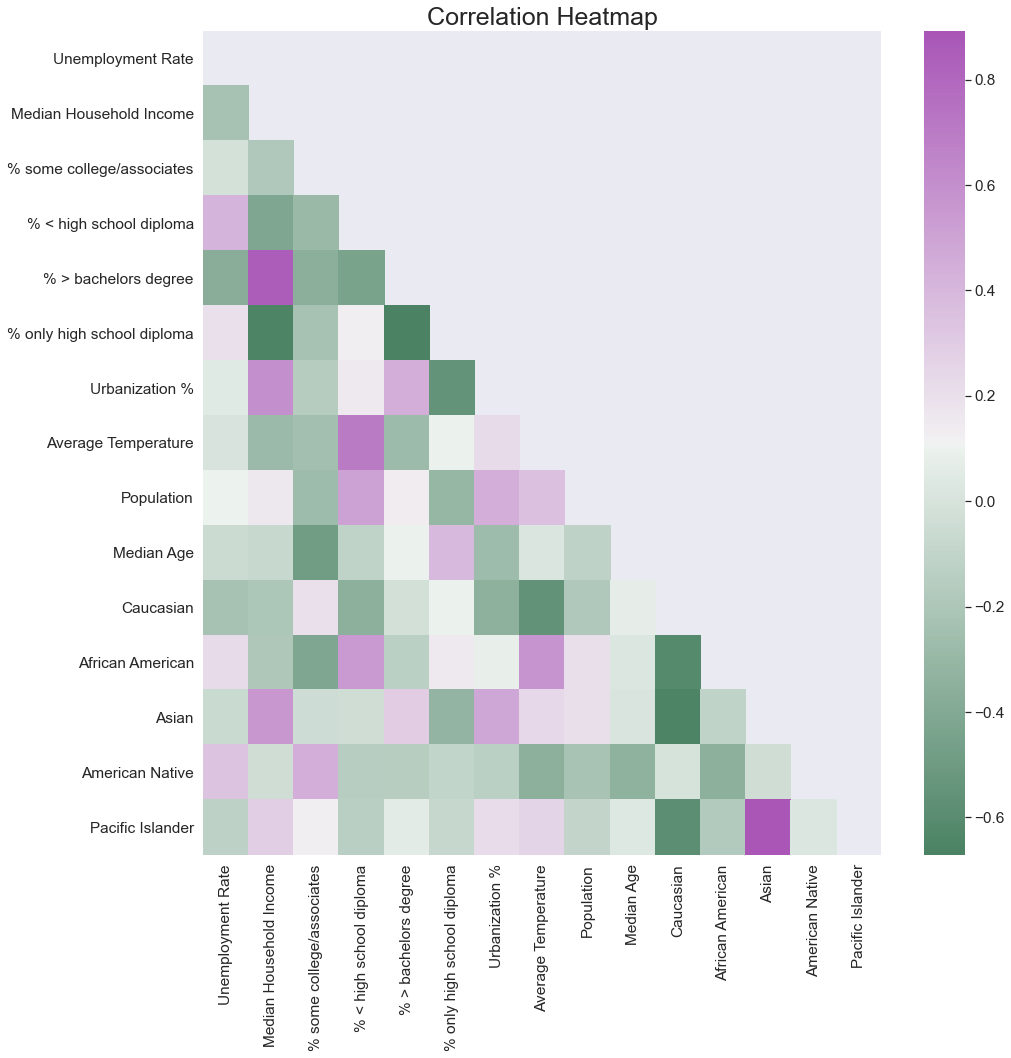

In [480]:
from matplotlib import rcParams
rcParams.update({'figure.autolayout': True})
# Examine correlations
stateEducationDataset = pd.read_csv("data/cleaned/educationStateDataset.csv")

heatmapColNames = ["Unemployment_rate_2019",
                    "Median_Household_Income_2019",
                    "% some college/associates",
                    "% < high school diploma",
                    "% > bachelors degree",
                    "% only high school diploma",
                    "Urbanization %",
                    "AverageTemperature",
                    "Pop_2019",
                    "Median Age",
                    "White",
                    "Black",
                    "Asian",
                    "American Native",
                    "Pacific Islander"]

predictorDataset = stateEducationDataset[heatmapColNames]
predictorDataset = predictorDataset.rename(columns={"Unemployment_rate_2019":"Unemployment Rate","Median_Household_Income_2019":"Median Household Income","AverageTemperature":"Average Temperature","Pop_2019":"Population","White":"Caucasian","Black":"African American"})

matrix = np.triu(predictorDataset.corr())

fig, ax = plt.subplots(figsize=(15,15))  
cmap = sns.diverging_palette(145, 300, s=60, as_cmap=True)
sns.heatmap(predictorDataset.corr(), annot=False, mask=matrix, ax=ax, cmap=cmap)
sns.set(font_scale=1.4)

plt.title("Correlation Heatmap", fontsize=25)
plt.show()

fig.savefig("data/results/correlation.png")

In [ ]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

predictorDataset = stateEducationDataset[colNames]
predictorDataset.set_index("FIPS Code", inplace=True)

#Merge independent and dependent variables to create a single dataframe to run out regression
predictorDataset = predictorDataset.drop(columns=["State"])
predictorDataset = predictorDataset.rename(columns={"Area Name":"State"})
predictorDataset["Median_Household_Income_2019"] = predictorDataset["Median_Household_Income_2019"]/10000
predictorDataset["Urbanization %"] = predictorDataset["Urbanization %"]/100 
df = predictorDataset.merge(dependentVarsDf,on="State",how='left')
print(df["Urbanization %"])

In [421]:
xcols = ["Median Age",
        "Black",
        "Asian",
        "White"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

Median Age    278.969678
Black           7.346189
Asian           5.229798
White         191.479308
dtype: float64


In [422]:
#Regression for misinformation
ycols = ["misperception_index"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     misperception_index   R-squared:                       0.449
Model:                             OLS   Adj. R-squared:                  0.400
Method:                  Least Squares   F-statistic:                     9.151
Date:                 Sat, 20 Feb 2021   Prob (F-statistic):           1.69e-05
Time:                         16:34:48   Log-Likelihood:                -118.37
No. Observations:                   50   AIC:                             246.7
Df Residuals:                       45   BIC:                             256.3
Df Model:                            4                                         
Covariance Type:             nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         41.9717     10.860      3.865      0.000      20.098      63.846
Median Age    -0.2157      0.179     -1.206      0.234      -0.576       0.145
Black         36.3249     10.270      3.537      0.001      15.640      57.010
Asian         49.5574     16.386      3.024      0.004      16.553      82.562
White         19.6002     11.152      1.758      0.086      -2.861      42.061
==============================================================================
Omnibus:                        1.137   Durbin-Watson:                   2.170
Prob(Omnibus):                  0.566   Jarque-Bera (JB):                1.098
Skew:                           0.216   Prob(JB):                        0.578
Kurtosis:                       2.417   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [327]:
#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     % belief in common misperceptions   R-squared:                       0.378
Model:                                           OLS   Adj. R-squared:                  0.322
Method:                                Least Squares   F-statistic:                     6.830
Date:                               Sat, 20 Feb 2021   Prob (F-statistic):           0.000220
Time:                                       14:47:18   Log-Likelihood:                -91.729
No. Observations:                                 50   AIC:                             193.5
Df Residuals:                                     45   BIC:                             203.0
Df Model:                                          4                                         
Covariance Type:                           nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         30.2345      6.374      4.743      0.000      17.396      43.073
Median Age    -0.2351      0.105     -2.239      0.030      -0.447      -0.024
Black          1.2554      6.028      0.208      0.836     -10.885      13.396
Asian        -19.3046      9.618     -2.007      0.051     -38.675       0.066
White         -8.3338      6.545     -1.273      0.209     -21.517       4.849
==============================================================================
Omnibus:                        0.205   Durbin-Watson:                   1.771
Prob(Omnibus):                  0.902   Jarque-Bera (JB):                0.081
Skew:                          -0.095   Prob(JB):                        0.961
Kurtosis:                       2.949   Cond. No.                     2.31e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.31e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [430]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

xcols = ["Median Age",
        "Urbanization %",
        "% > bachelors degree",
        "% < high school diploma",
        "% only high school diploma"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

Median Age                    421.728513
Urbanization %                 44.003164
% > bachelors degree          119.949468
% < high school diploma        23.349039
% only high school diploma    142.616335
dtype: float64


In [431]:
#Regression for misinformation
ycols = ["misperception_index"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             OLS Regression Results                            
===============================================================================
Dep. Variable:     misperception_index   R-squared:                       0.547
Model:                             OLS   Adj. R-squared:                  0.496
Method:                  Least Squares   F-statistic:                     10.64
Date:                 Sat, 20 Feb 2021   Prob (F-statistic):           9.64e-07
Time:                         16:46:06   Log-Likelihood:                -113.44
No. Observations:                   50   AIC:                             238.9
Df Residuals:                       44   BIC:                             250.4
Df Model:                            5                                         
Covariance Type:             nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
const                         32.7393      7.996      4.094      0.000      16.624      48.855
Median Age                     0.0782      0.207      0.378      0.707      -0.338       0.495
Urbanization %                 5.8802      3.281      1.792      0.080      -0.733      12.493
% > bachelors degree           0.2861      0.135      2.127      0.039       0.015       0.557
% < high school diploma        0.7780      0.161      4.838      0.000       0.454       1.102
% only high school diploma    -0.0331      0.164     -0.202      0.841      -0.364       0.298
==============================================================================
Omnibus:                        5.013   Durbin-Watson:                   2.102
Prob(Omnibus):                  0.082   Jarque-Bera (JB):                3.910
Skew:                           0.544   Prob(JB):                        0.142
Kurtosis:                       3.832   Cond. No.                     1.32e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.32e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [428]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

xcols = ["Median Age",
        "Urbanization %",
        "% > bachelors degree",
        "% < high school diploma",
        "% some college/associates"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

Median Age                   132.860734
Urbanization %                48.621692
% > bachelors degree          78.960576
% < high school diploma       24.100987
% some college/associates     47.334541
dtype: float64


In [429]:
#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                    OLS Regression Results                                   
=============================================================================================
Dep. Variable:     % belief in common misperceptions   R-squared:                       0.502
Model:                                           OLS   Adj. R-squared:                  0.446
Method:                                Least Squares   F-statistic:                     8.881
Date:                               Sat, 20 Feb 2021   Prob (F-statistic):           6.90e-06
Time:                                       16:41:58   Log-Likelihood:                -86.147
No. Observations:                                 50   AIC:                             184.3
Df Residuals:                                     44   BIC:                             195.8
Df Model:                                          5                                         
Covariance Type:                           nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                        22.5957      8.528      2.650      0.011       5.408      39.783
Median Age                   -0.2773      0.120     -2.313      0.025      -0.519      -0.036
Urbanization %               -3.9500      1.901     -2.078      0.044      -7.782      -0.118
% > bachelors degree          0.0021      0.071      0.030      0.976      -0.140       0.145
% < high school diploma       0.4226      0.119      3.542      0.001       0.182       0.663
% some college/associates     0.0021      0.095      0.022      0.983      -0.190       0.194
==============================================================================
Omnibus:                        1.919   Durbin-Watson:                   2.007
Prob(Omnibus):                  0.383   Jarque-Bera (JB):                1.279
Skew:                          -0.382   Prob(JB):                        0.527
Kurtosis:                       3.172   Cond. No.                     2.44e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.44e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [401]:
#Regression for misinformation
ycols = ["% belief in common misperceptions"]
y = df[ycols].astype(float)

clf = LinearRegression()
clf.fit(X, y)

print(clf.score(X,y))
print(clf.coef_)

0.4528890976892711
[[-0.20569612 -0.07241116  0.33716854]]


In [388]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

xcols = ["Median Age",
        "% some college/associates",
        "% > bachelors degree",
        "White",
        "Black",
        "Asian",
        "Urbanization %",
        "% < high school diploma",
        "AverageTemperature"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

Median Age                   351.361481
% some college/associates     76.617285
% > bachelors degree         105.561607
White                        532.803904
Black                         20.082649
Asian                         16.252384
Urbanization %                61.991562
% < high school diploma       47.179297
AverageTemperature            20.536357
dtype: float64


In [448]:
#Regression for mobility
ycols = ["Mobility"]
y = df[ycols]

X = sm.add_constant(X)
est = sm.OLS(y, X).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Mobility   R-squared:                       0.798
Model:                            OLS   Adj. R-squared:                  0.753
Method:                 Least Squares   F-statistic:                     17.58
Date:                Sat, 20 Feb 2021   Prob (F-statistic):           2.64e-11
Time:                        17:48:08   Log-Likelihood:                -153.15
No. Observations:                  50   AIC:                             326.3
Df Residuals:                      40   BIC:                             345.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                       110.7092     40.599      2.727      0.009      28.656     192.762
White                        31.3454     26.912      1.165      0.251     -23.046      85.737
Black                        21.3547     27.506      0.776      0.442     -34.236      76.946
Asian                       -26.9274     43.858     -0.614      0.543    -115.567      61.712
Median Age                   -1.3482      0.515     -2.618      0.012      -2.389      -0.308
% some college/associates    -0.5729      0.404     -1.416      0.164      -1.390       0.245
Urbanization %              -21.0406      8.597     -2.447      0.019     -38.416      -3.665
% < high school diploma      -2.3268      0.559     -4.159      0.000      -3.458      -1.196
% > bachelors degree         -0.9268      0.293     -3.163      0.003      -1.519      -0.335
AverageTemperature           -0.3503      0.309     -1.134      0.263      -0.974       0.274
==============================================================================
Omnibus:                        1.050   Durbin-Watson:                   2.203
Prob(Omnibus):                  0.592   Jarque-Bera (JB):                0.488
Skew:                          -0.215   Prob(JB):                        0.784
Kurtosis:                       3.221   Cond. No.                     4.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

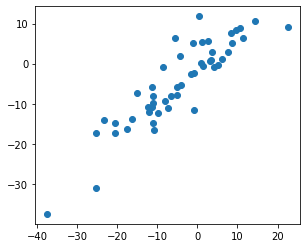

In [449]:
plt.scatter(y, est.fittedvalues)
plt.gca().set_aspect('equal', adjustable='box')

In [433]:
colNames = ["FIPS Code",
            "State",
            'Area Name',
            "Unemployment_rate_2019",
            "Median_Household_Income_2019",
            "% some college/associates",
            "% < high school diploma",
            "% > bachelors degree",
            "% only high school diploma",
            "Urbanization %",
            "AverageTemperature",
            "Pop_2019",
            "Median Age",
            "White",
            "Black",
            "Asian",
            "American Native",
            "Pacific Islander"]

xcols = ["White",
        "Black",
        "Asian",
        "Median Age",
        "% some college/associates",
        "Urbanization %",
        "% < high school diploma",
        "% > bachelors degree",
        "AverageTemperature"]
X = df[xcols]
X[X < 0] = 0
print(pd.Series([variance_inflation_factor(X.values, i) 
               for i in range(X.shape[1])], 
              index=X.columns))

White                        532.803904
Black                         20.082649
Asian                         16.252384
Median Age                   351.361481
% some college/associates     76.617285
Urbanization %                61.991562
% < high school diploma       47.179297
% > bachelors degree         105.561607
AverageTemperature            20.536357
dtype: float64


In [484]:
#Regression for covid
ycols = ["positivity_rate"]
y = df[ycols]

X = sm.add_constant(X)
positivityModel = sm.OLS(y, X).fit()
positivityModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        positivity_rate   R-squared:                       0.431
Model:                            OLS   Adj. R-squared:                  0.303
Method:                 Least Squares   F-statistic:                     3.372
Date:                Sat, 20 Feb 2021   Prob (F-statistic):            0.00368
Time:                        20:53:42   Log-Likelihood:                 85.729
No. Observations:                  50   AIC:                            -151.5
Df Residuals:                      40   BIC:                            -132.3
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.4074      0.342      1.192      0.240      -0.283       1.098
White                         0.2711      0.226      1.197      0.238      -0.187       0.729
Black                         0.2082      0.231      0.899      0.374      -0.260       0.676
Asian                         0.1275      0.369      0.345      0.732      -0.619       0.873
Median Age                   -0.0120      0.004     -2.769      0.008      -0.021      -0.003
% some college/associates     0.0011      0.003      0.318      0.752      -0.006       0.008
Urbanization %               -0.0663      0.072     -0.917      0.365      -0.213       0.080
% < high school diploma      -0.0057      0.005     -1.206      0.235      -0.015       0.004
% > bachelors degree         -0.0028      0.002     -1.116      0.271      -0.008       0.002
AverageTemperature            0.0055      0.003      2.116      0.041       0.000       0.011
==============================================================================
Omnibus:                       23.974   Durbin-Watson:                   1.952
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               37.985
Skew:                           1.566   Prob(JB):                     5.64e-09
Kurtosis:                       5.903   Cond. No.                     4.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

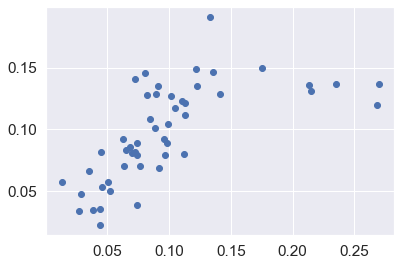

In [485]:
plt.scatter(y, positivityModel.fittedvalues)
plt.gca().set_aspect('equal', adjustable='box')

In [495]:
#Regression for covid
ycols = ["Output"]
y = df[ycols]

X = sm.add_constant(X)
deathModel = sm.OLS(y, X).fit()
deathModel.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 Output   R-squared:                       0.433
Model:                            OLS   Adj. R-squared:                  0.306
Method:                 Least Squares   F-statistic:                     3.399
Date:                Sat, 20 Feb 2021   Prob (F-statistic):            0.00348
Time:                        20:57:24   Log-Likelihood:                 88.251
No. Observations:                  50   AIC:                            -156.5
Df Residuals:                      40   BIC:                            -137.4
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
=============================================================================================
                                coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------------
const                         0.4868      0.325      1.498      0.142      -0.170       1.143
White                        -0.0897      0.215     -0.416      0.679      -0.525       0.346
Black                         0.0323      0.220      0.147      0.884      -0.413       0.477
Asian                        -0.4206      0.351     -1.198      0.238      -1.130       0.289
Median Age                   -0.0014      0.004     -0.341      0.735      -0.010       0.007
% some college/associates    -0.0068      0.003     -2.104      0.042      -0.013      -0.000
Urbanization %                0.1831      0.069      2.662      0.011       0.044       0.322
% < high school diploma       0.0004      0.004      0.080      0.937      -0.009       0.009
% > bachelors degree         -0.0039      0.002     -1.675      0.102      -0.009       0.001
AverageTemperature           -0.0017      0.002     -0.676      0.503      -0.007       0.003
==============================================================================
Omnibus:                        2.610   Durbin-Watson:                   1.984
Prob(Omnibus):                  0.271   Jarque-Bera (JB):                2.469
Skew:                           0.520   Prob(JB):                        0.291
Kurtosis:                       2.677   Cond. No.                     4.41e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 4.41e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

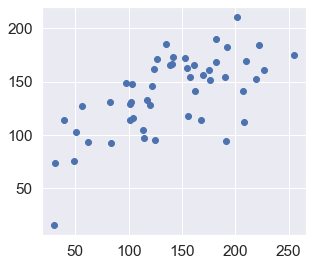

In [490]:
plt.scatter(y, deathModel.fittedvalues)
plt.gca().set_aspect('equal', adjustable='box')

In [498]:
demographicPredictions = pd.DataFrame()
demographicPredictions["Positivity Rate"] = positivityModel.fittedvalues
demographicPredictions["Deaths / Population"] = deathModel.fittedvalues/100000

print(demographicPredictions)
demographicPredictions.to_csv("data/results/demographicPredictions.csv")

    Positivity Rate  Deaths / Population
0          0.131342         1.546062e-06
1          0.066475         1.137148e-06
2          0.111910         1.414363e-06
3          0.149364         1.514667e-06
4          0.070300         1.284517e-06
5          0.081468         1.291911e-06
6          0.035856         1.692311e-06
7          0.070367         1.850668e-06
8          0.101423         1.659700e-06
9          0.128753         1.719794e-06
10         0.034152         1.565863e-07
11         0.136694         1.143184e-06
12         0.080791         1.608905e-06
13         0.128801         1.681488e-06
14         0.136078         1.141502e-06
15         0.136491         1.177524e-06
16         0.127013         1.486850e-06
17         0.145686         2.102103e-06
18         0.047401         7.607294e-07
19         0.057708         1.716103e-06
20         0.034381         1.605558e-06
21         0.082969         1.414362e-06
22         0.089053         1.047190e-06
23         0.150